Tool to see different frames of RPs and catheter data

In [1]:
import sys,os
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
try:
    import pickle5 as pickle
except: 
    import pickle

from IPython.display import display
import ipywidgets as widgets

upperDir = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(upperDir,'aux-functions'))
sys.path.append(os.path.join(upperDir,'recurrence'))
from RecurrenceComputation import RecurrenceComputation
import egm_processing as egmp

In [2]:
CATPATH=r'D:\\vgmar\\model_data\\exp915'
RECPATH=r'D:\\vgmar\\model_data\\exp915'

experiment = 'exp915f04'#'exp909b304'
cat='PLA'

CGroup = pickle.load(open(os.path.join(CATPATH,experiment+'_CatheterData.catG'),'rb'))
fs = CGroup.Catheters[cat].SamplingFrequency

## Calculate global distance matrix for catheter
with open(os.path.join(RECPATH,experiment+'_RecurrenceAnalyses.pkl'),'rb') as output:
    DistanceMatrices =  pickle.load(output)
    EstimatedAFCLs =  pickle.load(output)

In [3]:
Elec = CGroup.Catheters[cat]
recComp = RecurrenceComputation()
recComp.SampleShift = 5
recComp.TheilerAFCLNumber = 0.5
recComp.ExpectedAFRecurrenceRate = 1

estimatedAFCL = EstimatedAFCLs[cat]
minLineLength = (estimatedAFCL*Elec.SamplingFrequency)//recComp.SampleShift

# downsampledBlock = Block//recComp.SampleShift

partDM = DistanceMatrices[cat]#[downsampledBlock[0]:downsampledBlock[1],
#                                downsampledBlock[0]:downsampledBlock[1]]

RP, recurrenceTime, recurrenceThreshold, partDM = \
            recComp.ComputeRecurrencePlot(partDM, fs, estimatedAFCL,recurrenceThreshold= 0.15)

recurrenceTime = recurrenceTime#+Block[0]/1000                    
RPE = recComp.ErodeRP(RP,partDM,linear=True)

phaseSignal,_ = egmp.ComputeActivationPhaseSignal(Elec)

xi = Elec.ElectrodesTemplate[:,0]
yi = Elec.ElectrodesTemplate[:,1]

In [7]:
def plotCatheterAndRP(tStep,Elec,RPE,recurrenceTime):
    frame = np.where(recurrenceTime==tStep)[0][0]
    sampleSteps = (recurrenceTime*1000).astype(int)

    xi = Elec.ElectrodesTemplate[:,0]
    yi = Elec.ElectrodesTemplate[:,1]
    
    fig, ax = plt.subplots(1,2,figsize=(14.4,5.75),gridspec_kw={'width_ratios': [1, 1]})

    xx,yy = np.where(RPE)
    ax[0].scatter(recurrenceTime[xx],recurrenceTime[yy],color='k',s=0.005)
    ax[0].set_xticks(recurrenceTime[::500])
    ax[0].set_yticks(recurrenceTime[::500])
    ax[0].set_xlim([recurrenceTime[0],recurrenceTime[-1]])
    ax[0].set_ylim([recurrenceTime[0],recurrenceTime[-1]])
    vline = ax[0].axvline(recurrenceTime[frame],color='r',linewidth=2)
    ax[0].set_xlabel('Time (s)',fontsize = 18)
    ax[0].set_ylabel('Time (s)',fontsize = 18)
    ax[0].tick_params(labelsize=16)


    ax[1].set(xlim=(yi[0]-1.5,yi[-1]+1.5), ylim=(xi[0]-2.5,xi[-1]+2.5))
    ax[1].autoscale(False)

    ax[1].set_xlabel('Position (mm)',fontsize = 18)
    ax[1].set_ylabel('Position (mm)',fontsize = 18)
    ax[1].tick_params(labelsize=16)

    cax = ax[1].scatter(yi,xi,c =phaseSignal[sampleSteps[frame],:],cmap = 'gnuplot',#origin='lower',
                    # extent= [yi[0],yi[1],xi[0],xi[1]],
                    marker='s',s=5000,
                    vmin = -np.pi,vmax = np.pi)#,shading='nearest')

    cbar = fig.colorbar(cax, ticks=[-np.pi, 0, np.pi],ax = ax[1])
    cbar.set_label('Phase (rad)', fontsize = 24)
    cbar.ax.set_yticklabels(['$-\pi$', '0', '$+\pi$'], fontsize = 24)   
    fig.suptitle('Catheter %s - t= %d ms'%(cat,sampleSteps[0]), fontsize = 28)


interactive(children=(FloatSlider(value=0.085, continuous_update=False, description='Time step (ms)', max=9.93…

<function __main__.plotCatheterAndRP(tStep, Elec, RPE, recurrenceTime)>

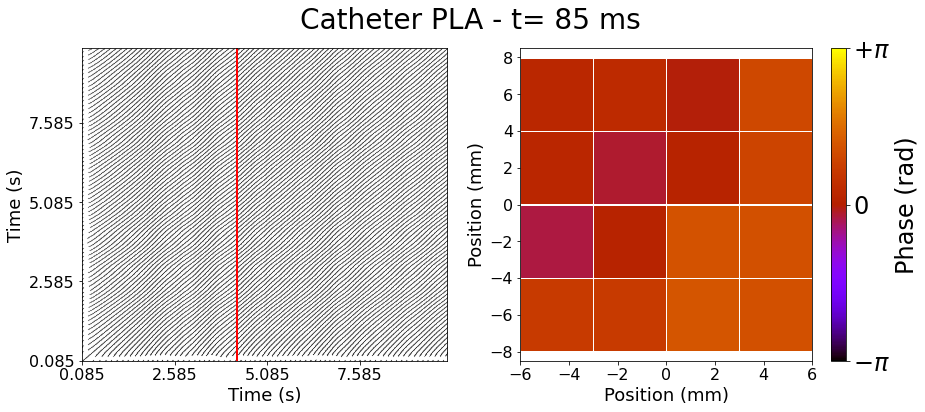

In [9]:
recurrenceTime = np.round(recurrenceTime,3)
tStepWidget = widgets.FloatSlider(value=recurrenceTime[0],min = recurrenceTime[0],max=recurrenceTime[-1],
                                  description='Time step (ms)',
                                    step=0.005,
                                  disabled=False,continuous_update=False)


w = widgets.interact_manual(plotCatheterAndRP,tStep=tStepWidget,
                            Elec=widgets.fixed(Elec),
                            RPE=widgets.fixed(RPE),
                            recurrenceTime=widgets.fixed(recurrenceTime))
w

In [6]:
np.where(recurrenceTime==3.935)[0][0]

770

In [11]:
yi

array([-4.5, -4.5, -4.5, -4.5, -1.5, -1.5, -1.5, -1.5,  1.5,  1.5,  1.5,
        1.5,  4.5,  4.5,  4.5,  4.5])